In [1]:
import os
import pywt
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN

import yaml
import pickle
import importlib
from types import SimpleNamespace
from quantus.metrics import Complexity

from physioex.physioex.data import PhysioExDataModule
from physioex.physioex.train.models.load import load_model

from src.utils import split_string
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# set seed
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [4]:
target_package = "physioex.train.networks.utils.target_transform"
target_class = "get_mid_label"
target = getattr(importlib.import_module(target_package), target_class)

set_seed(42)

datamodule = PhysioExDataModule(
    datasets=["sleepedf"],     # list of datasets to be used
    batch_size=64,            # batch size for the DataLoader
    preprocessing="raw",       # preprocessing method
    selected_channels=["EEG"], # channels to be selected
    sequence_length=7,         # length of the sequence
    target_transform= target,  # since seq to epoch, target seq
    num_workers = 8,          # number of parallel workers
    data_folder = "data"    # path to the data folder
)

In [16]:
# get the test DataLoaders
train_loader = datamodule.train_dataloader()
validation_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()


print(f"Number of batches in the train set: {len(train_loader)}")
print(f"Number of batches in the validation set: {len(validation_loader)}")
print(f"Number of batches in the test set: {len(test_loader)}")

Number of batches in the train set: 2048
Number of batches in the validation set: 573
Number of batches in the test set: 412


In [ ]:
sleep_stages_counts = np.zeros(5)
for i, batch in enumerate(train_loader):
    sleep_stages_counts += np.bincount(batch[1].numpy(), minlength=5)

print(f"Train sleep stages counts: {sleep_stages_counts}")


Train sleep stages counts: [40646. 14489. 47842. 10413. 17652.]


In [ ]:
sleep_stages_val = np.zeros(5)
for i, batch in enumerate(validation_loader):
    sleep_stages_val += np.bincount(batch[1].numpy(), minlength=5)

print(f"Val sleep stages counts: {sleep_stages_val}")

sleep_stages_test = np.zeros(5)
for i, batch in enumerate(test_loader):
    sleep_stages_test += np.bincount(batch[1].numpy(), minlength=5)

print(f"Test sleep stages counts: {sleep_stages_test}")

Val sleep stages counts: [15958.  4249. 11343.   915.  4147.]
Train sleep stages counts: [7844. 2784. 9947. 1711. 4036.]


In [21]:
# print total counts
print(f"Train sleep stages counts: {np.sum(sleep_stages_counts)}")
print(f"Val sleep stages counts: {np.sum(sleep_stages_val)}")
print(f"Test sleep stages counts: {np.sum(sleep_stages_test)}")


Train sleep stages counts: 131042.0
Val sleep stages counts: 36612.0
Test sleep stages counts: 26322.0


In [6]:
# load the model
with open("./config.yaml", "r") as file:
        config = yaml.safe_load(file)

network_config = config["model_config"]

# load the model class
model_package, model_class = config["model"].split(":")
model_class = getattr(importlib.import_module(model_package), model_class)

# casting the float types
network_config['learning_rate'] = float(network_config['learning_rate'])
network_config['weight_decay'] = float(network_config['weight_decay'])
network_config['adam_beta_1'] = float(network_config['adam_beta_1'])
network_config['adam_beta_2'] = float(network_config['adam_beta_2'])
network_config['adam_epsilon'] = float(network_config['adam_epsilon'])

model_path = "./model/checkpoint/fold=-1-epoch=19-step=19898-val_acc=0.83.ckpt"
model = load_model(
    model = model_class,
    model_kwargs = network_config,
    ckpt_path = model_path
)

print(f"Model loaded successfully {model}")



1
Model loaded successfully Chambon2018Net(
  (nn): Net(
    (epoch_encoder): SleepStagerChambon2018(
      (feature_extractor): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, np.int64(50)), stride=(1, 1), padding=(0, np.int64(25)))
        (1): Identity()
        (2): ReLU()
        (3): MaxPool2d(kernel_size=(1, np.int64(13)), stride=(1, np.int64(13)), padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(8, 8, kernel_size=(1, np.int64(50)), stride=(1, 1), padding=(0, np.int64(25)))
        (5): Identity()
        (6): ReLU()
        (7): MaxPool2d(kernel_size=(1, np.int64(13)), stride=(1, np.int64(13)), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (clf): Linear(in_features=952, out_features=5, bias=True)
    (drop): Dropout(p=0.5, inplace=False)
  )
  (wacc): MulticlassAccuracy()
  (macc): MulticlassAccuracy()
  (wf1): MulticlassF1Score()
  (mf1): MulticlassF1Score()
  (ck): MulticlassCohenKappa()
  (pr): MulticlassPrecision()
  (rc): MulticlassRecall()
  (

In [7]:
# read data
folder = 'public/sleepedf/'
path = f'{folder}wavelet_coif4_5_64.pkl'

with open(path, 'rb') as f:
    attributions = pickle.load(f)
print(f"Attributions loaded from {path}")

Attributions loaded from public/sleepedf/wavelet_coif4_5_64.pkl


In [7]:
# evaluate wavelet
fs = 100
T = 30
data_len = T * fs
batch_size = 128
wavelet = 'coif'
w_len = 4
level = 5
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)

wavelet_coif4_5_128


In [8]:
# plot scaleograms

def plot_dwt_scaleogram(coeffs, w='db1', fs=16, t=1, label=0):
    """
    coeffs: list of coefficients
    fs: sampling frequency
    """
    # Create a figure
    plt.figure(figsize=(10, 6))

    # compute the frequency bands
    freq_bands = [fs / (2 ** (j + 1)) for j in range(len(coeffs[0]))]   # bands
    freq_bands.append(0)                                             # lowest frequency
    freq_bands = freq_bands[::-1]                                    # reverse the order

    print(len(freq_bands))
    
    scaleogram = np.array(coeffs)
    # scaleogram = scaleogram[:, :]
    scaleogram = np.abs(scaleogram)
    
    # normalize the scaleogram
    scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)

    # Create a meshgrid for time and frequency
    time = np.linspace(0, t, fs * t )
    time = np.concatenate([time, [time[-1] + (1/(fs*t))]])

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, scaleogram.T, shading='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f'Scaleogram of class {label} of wavelet {w}')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    plt.tight_layout()
    plt.show()

In [9]:
def plot_fft(signal, fs):
    N = len(signal)
    T = 1 / fs
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title("FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

In [11]:
for batch in test_loader:
    x, y = batch
    break

In [14]:
print(x.shape)
signal = x.detach().cpu().numpy().transpose(1, 2, 0, 3)[3]
small_test = x.detach().cpu().numpy().transpose(1, 2, 0, 3)[3].flatten()
len(small_test)

torch.Size([64, 7, 1, 3000])


192000

3000
(64,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]


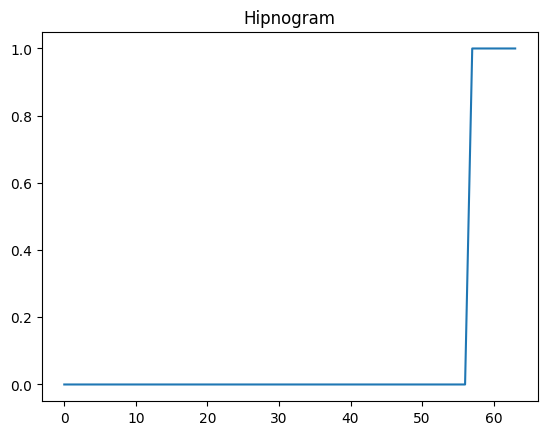

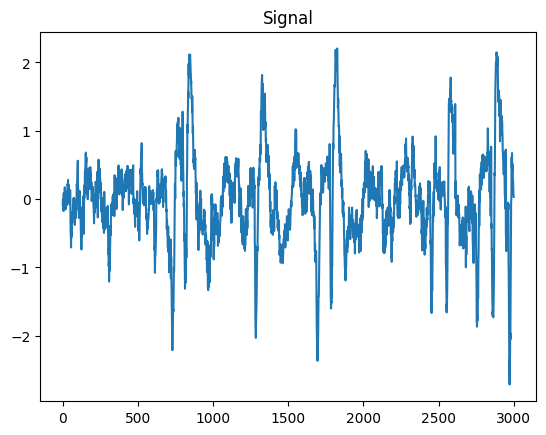

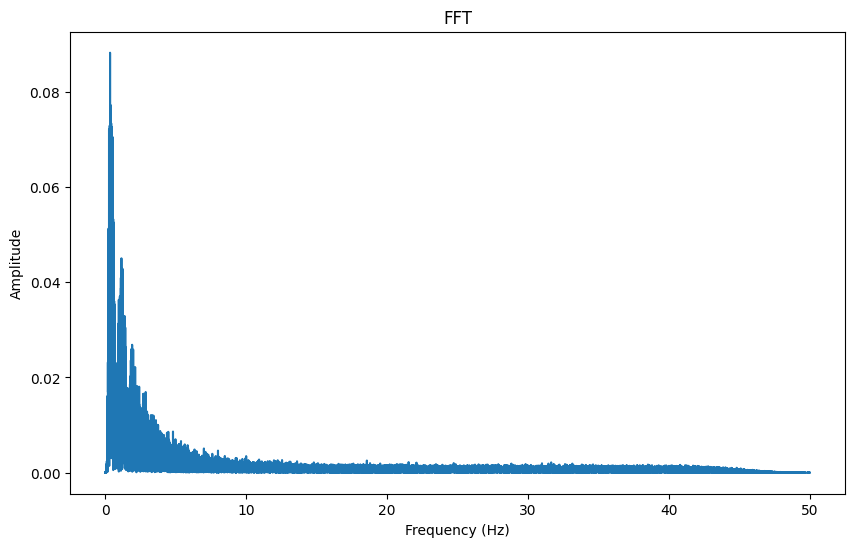

NameError: name 'upsampling_wavedec' is not defined

In [15]:
signal = x[0][3][0]
print(len(signal))
y_np = y.detach().cpu().numpy()
print(y_np.shape)
print(y_np)

# plot the hipnogram
plt.figure()
plt.plot(y.detach().cpu().numpy())
plt.title("Hipnogram")
plt.show()

# plot the signal
plt.figure()
plt.plot(signal)
plt.title("Signal")
plt.show()

# plot fft
plot_fft(small_test, 100)

coeffs = pywt.wavedec(signal, 'coif4', level=5)
coeffs = upsampling_wavedec(len(signal), coeffs)
print(len(coeffs))
plot_dwt_scaleogram(coeffs.T, fs=100, t=30, w='coif4', label=0)

6
7


<Figure size 1000x600 with 0 Axes>

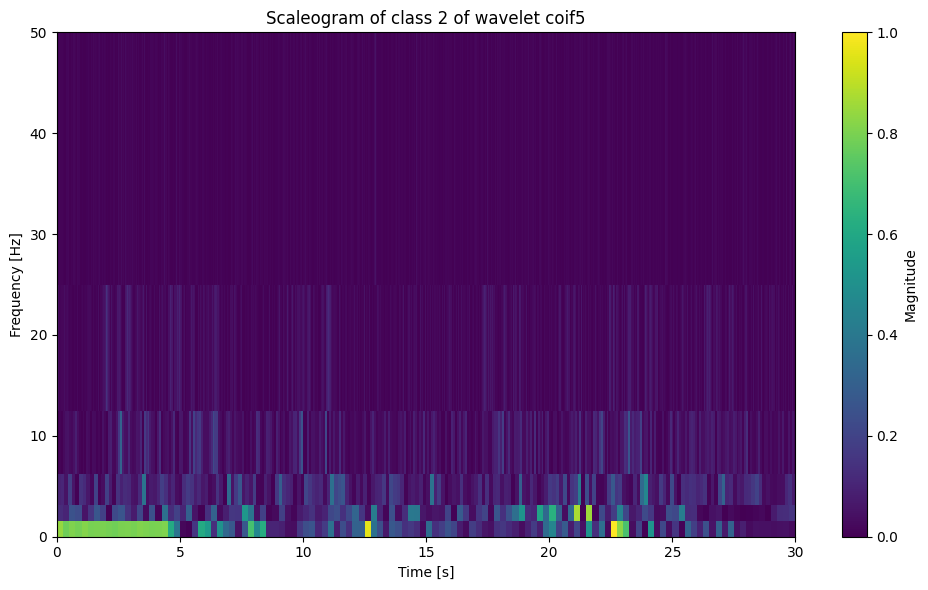

In [ ]:
signal_2 = x[120][3][0]

coeffs = pywt.wavedec(signal_2, 'coif5', level=5)
coeffs = upsampling_wavedec(len(signal_2), coeffs)
print(len(coeffs))
plot_dwt_scaleogram(coeffs.T, fs=100, t=30, w='coif5', label=2)

In [21]:
def plot_scaleogram_wav_heatmap(signal, attribution, prediction:int, label:int, fs=1000 ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(len(attribution[0]))]   # bands
    freq_bands.append(0)                                        # lowest frequency
    freq_bands = freq_bands[::-1]                               # reverse the order
    # print(freq_bands)

    if label == 0:
        class_name = "Wake"
    elif label == 1:
        class_name = "N1"
    elif label == 2:
        class_name = "N2"
    elif label == 3:
        class_name = "N3/N4"
    elif label == 4:
        class_name = "REM"
    

    time = np.linspace(0, signal / fs, signal)
    

    # normalize attribution scores to [0,1]
    attribution = np.abs(attribution)
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attr_norm[1:,:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'{class_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [15]:
print(attributions.keys())

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_coif4_5_128', 'filtermasks_wavelet_coif4_5_128'])


In [14]:
import torch.nn.functional as F

print(attributions['predictions'][0])

probabilities = F.softmax(attributions['predictions'][0], dim=0)
print(probabilities)

predicted = torch.argmax(attributions['predictions'][0], dim=0)
print(predicted)


predicted = []

for p in attributions['predictions']:
    # probabilities = F.softmax(p, dim=0)
    predicted.append(torch.argmax(p, dim=0))

print(len(predicted))



tensor([ 3.7968, -1.1244, -2.3120, -9.1935, -2.5675])
tensor([9.8889e-01, 7.2094e-03, 2.1984e-03, 2.2569e-06, 1.7028e-03])
tensor(0)
26322


wavelet_coif4_5_128
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3200
3264
3328
3392
3456
3520
3584
3648
3712
3776
3840
3904
3968
4032
4096
4160
4224
4288
4352
4416
4480
4544
4608
4672
4736
4800
4864
4928
4992
5056
5120
5184
5248
5312
5376
5440
5504
5568
5632
5696
5760
5824
5888
5952
6016
6080
6144
6208
6272
6336
6400
6464
6528
6592
6656
6720
6784
6848
6912
6976
7040
7104
7168
7232
7296
7360
7424
7488
7552
7616
7680
7744
7808
7872
7936
8000
8064
8128
8192
8256
8320
8384
8448
8512
8576
8640
8704
8768
8832
8896
8960
9024
9088
9152
9216
9280
9344
9408
9472
9536
9600
9664
9728
9792
9856
9920
9984
10048
10112
10176
10240
10304
10368
10432
10496
10560
10624
10688
10752
10816
10880
10944
11008
11072
11136
11200
11264
11328
11392
11456
11520
11584
11648
11712
11776
11840
11904
11968
12032
12096
12160
12224
1228

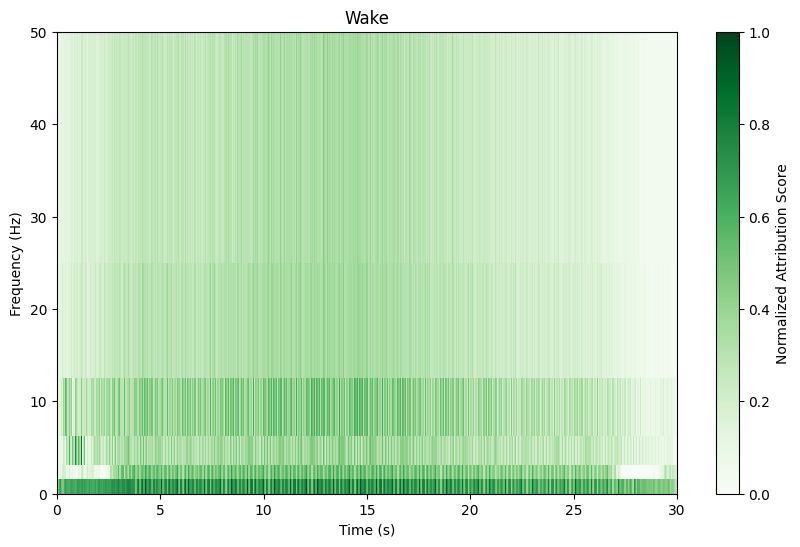

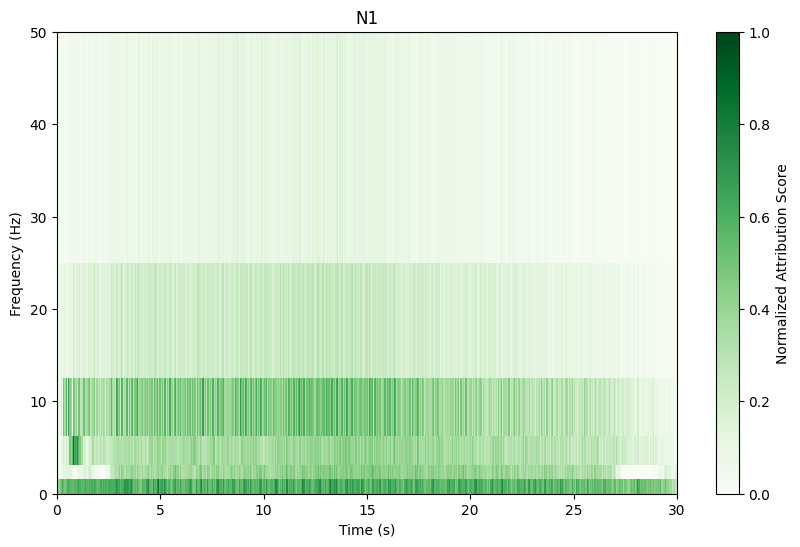

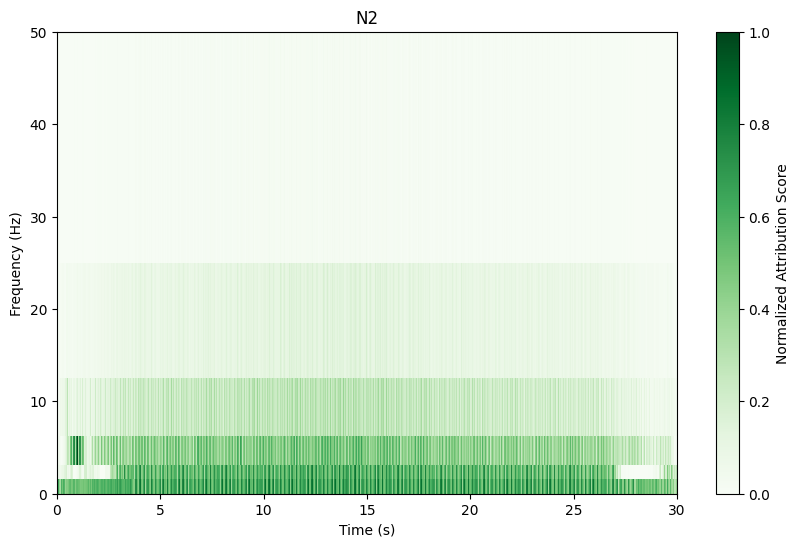

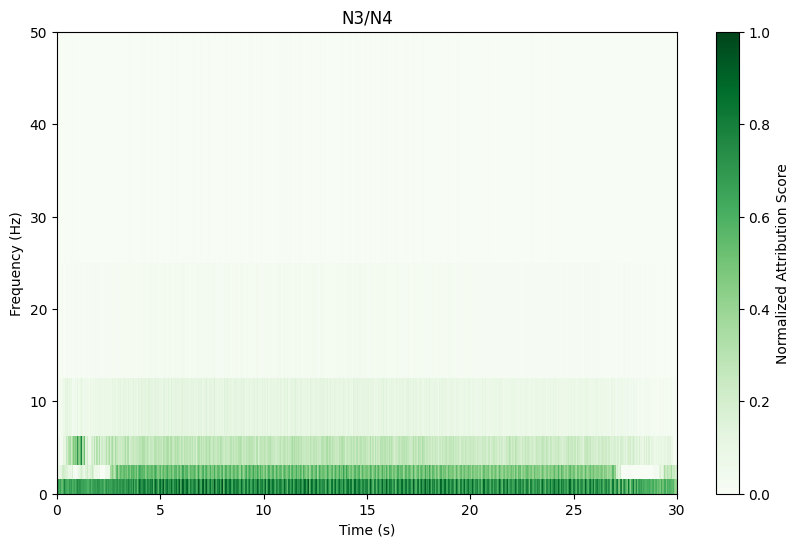

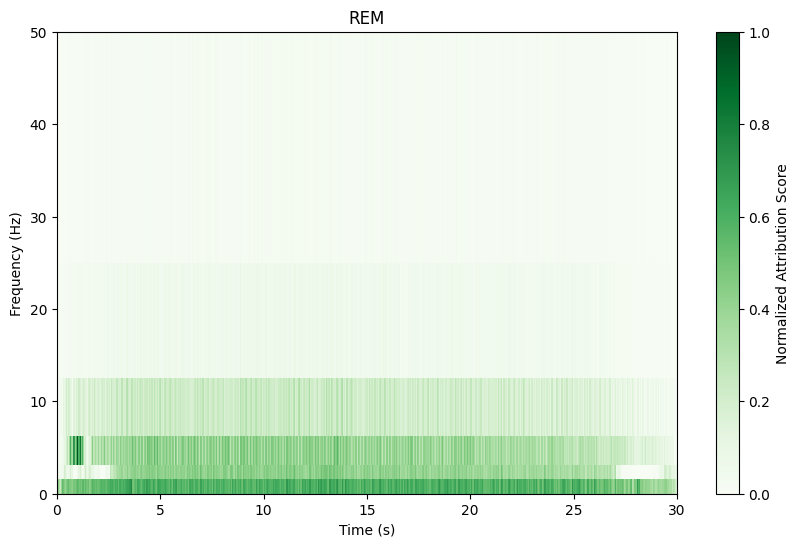

In [22]:
# "Sleep stage W": 0,
# "Sleep stage 1": 1,
# "Sleep stage 2": 2,

counts_0 = 0
counts_1 = 0
counts_2 = 0
counts_3 = 0
counts_4 = 0

data_length = 3000
fs = 100

# attributions['insertion']['wavelet_db1_4_128'] = scores

set_seed(42)
key_ = 'wavelet_coif4_5_128'
print(key_)

# for key in attributions['insertion'].keys():
#     print(key)

# method, wavelet, max_level, batch_size = key.split('_')
# max_level = int(max_level)

masks_0 = np.zeros_like(attributions[key_][0][0][0])
masks_1 = np.zeros_like(attributions[key_][0][0][0])
masks_2 = np.zeros_like(attributions[key_][0][0][0])
masks_3 = np.zeros_like(attributions[key_][0][0][0])
masks_4 = np.zeros_like(attributions[key_][0][0][0])

index = 0
correct = 0

for i in range(len(test_loader)):
    scores = attributions[key_][i]
    print(index)

    for j in range(len(scores)):
        if predicted[index] == attributions['labels'][index]:
            correct += 1
            results = scores[j][3].detach().cpu().numpy()    
            # print(index)
            if attributions['labels'][index] == 0:
                counts_0 += 1
                masks_0 += results
            elif attributions['labels'][index] == 1:
                counts_1 += 1
                masks_1 += results
            elif attributions['labels'][index] == 2:
                counts_2 += 1
                masks_2 += results
            elif attributions['labels'][index] == 3:
                counts_3 += 1
                masks_3 += results
            elif attributions['labels'][index] == 4:
                counts_4 += 1
                masks_4 += results

        index += 1

masks_0 /= counts_0
masks_1 /= counts_1
masks_2 /= counts_2
masks_3 /= counts_3
masks_4 /= counts_4

print(f"Total samples: {len(predicted)}")
print(f"Correctly classified: {correct}")
print(f"Total correctly classified: {counts_0 + counts_1 + counts_2 + counts_3 + counts_4}")
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}, label 2: {counts_2}, label 3: {counts_3}, label 4: {counts_4}")
print(f"Shape of mask 0: {masks_0.shape}, mask 1: {masks_1.shape}, mask 2: {masks_2.shape}, mask 3: {masks_3.shape}, mask 4: {masks_4.shape}")

plot_scaleogram_wav_heatmap(data_length, masks_0, prediction=0, label=0, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_1, prediction=1, label=1, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_2, prediction=2, label=2, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_3, prediction=3, label=3, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_4, prediction=4, label=4, fs=fs)

# Counts of label 0: 3887, label 1: 1418, label 2: 5084, label 3: 809, label 4: 1986

    

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List


def plot_frequency_attribution(
    masks: List[np.ndarray],
    labels: List[int],
    fs: int = 100,
    data_length: int = 3000,
    max_level: int = 5,
    figsize: Tuple[int, int] = (20, 5)
):
    """
    Plot the frequency band attribution for each sleep stage.
    
    Args:
        masks: List of averaged wavelet masks for each sleep stage
        labels: List of corresponding sleep stage labels
        fs: Sampling frequency
        data_length: Length of the data in samples
        max_level: Maximum wavelet decomposition level
        figsize: Figure size (width, height)
    """
    # Calculate frequency bands based on wavelet decomposition
    # For wavelet transform, each level represents a different frequency band
    # The frequency bands are approximately: [f/2^(level+1), f/2^level]
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(max_level+1)]   # bands
    freq_bands.append(0)                                            # lowest frequency
    freq_bands = freq_bands[::-1]    

    print(freq_bands)

    # divide the bands value between 2
    freq_bands = [(freq_bands[i] + freq_bands[i+1]) / 2 for i in range(len(freq_bands)-1)]
    
    print(freq_bands)

    # Create subplots in a single row
    fig, axes = plt.subplots(1, len(masks), figsize=figsize, sharey=True)
    
    # Find the maximum absolute value for normalization
    max_abs_val = max(np.max(np.abs(np.sum(mask, axis=0))) for mask in masks)
    
    for i, (mask, label) in enumerate(zip(masks, labels)):
        # Integrate over time dimension (axis=1)
        freq_attribution = np.sum(mask, axis=0)
        
        # Normalize the attribution scores
        freq_attribution = freq_attribution / max_abs_val
        
        # Plot the frequency attribution
        ax = axes[i]
        
        # Create a line plot with frequency bands
        ax.plot(freq_bands, freq_attribution, marker='o', linestyle='-')
        
        # Format the plot
        ax.set_title(f'{label}', pad=10)
        ax.set_xlabel('Frequency (Hz)')
        
        # Set consistent limits
        ax.set_xlim(0, 50)
        ax.set_ylim(0, 1)
    
    # Add common x-axis label
    plt.tight_layout()
    plt.show()

[0, 1.5625, 3.125, 6.25, 12.5, 25.0, 50.0]
[0.78125, 2.34375, 4.6875, 9.375, 18.75, 37.5]


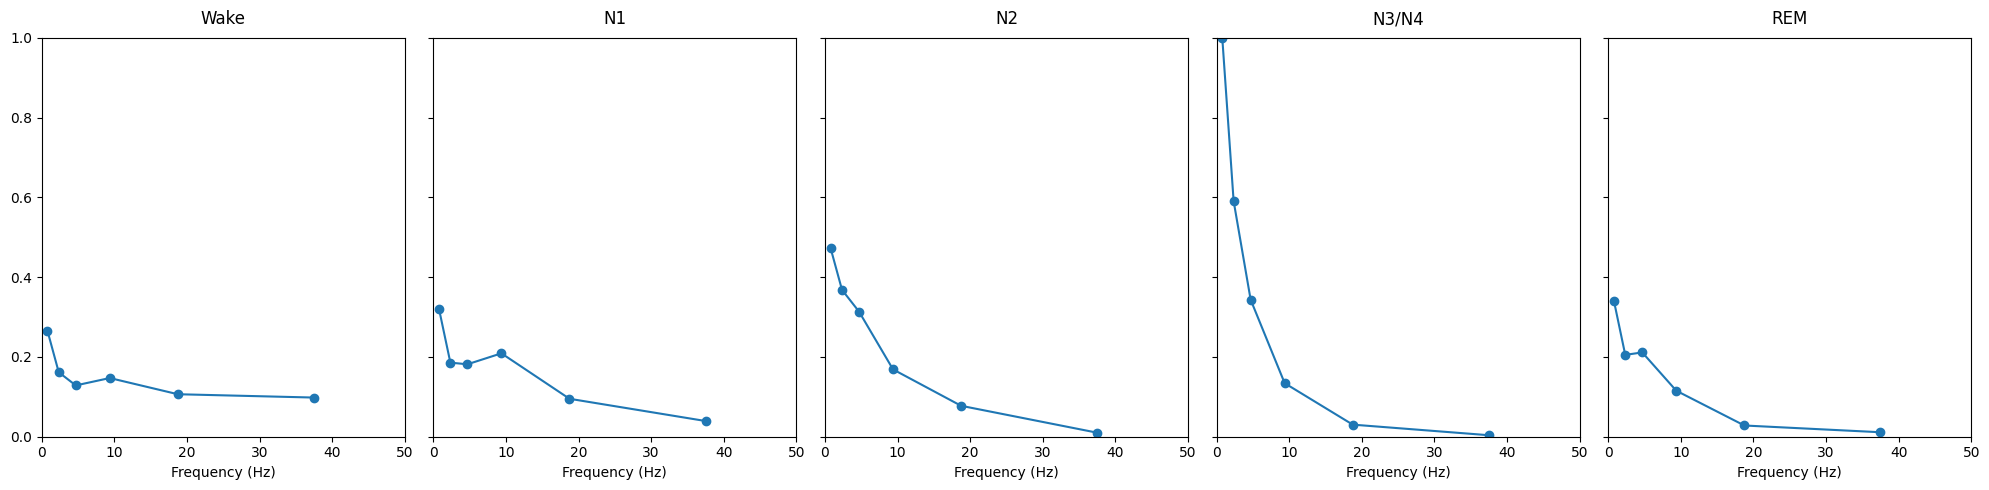

In [24]:
masks = [masks_0, masks_1, masks_2, masks_3, masks_4]
labels = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']
    
plot_frequency_attribution(masks, labels, fs=100, data_length=3000, max_level=5)